In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import gc
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras.backend as K

import cv2

import open3d as o3

from functools import partial

from mpl_toolkits.mplot3d import Axes3D

from pathlib import Path

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.
C:\RoboDK\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\RoboDK\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\RoboDK\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\RoboDK\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Pas

In [3]:
from data_generator.lib.cal_3D_intersection_angle import cal_3D_intersection_angle
from data_generator.lib.cal_3D_angles import cal_3D_angles
from data_generator.lib.dashift import dataShift
from data_generator.lib.eva_rms import eva_rms
from data_generator.lib.gather_pcd import gather_pcd
from data_generator.lib.get_files_names import get_files_names
from data_generator.lib.get3DMatrix_AOV import get3DMatrix
from data_generator.lib.getAABBSize import getAABBSize
from data_generator.lib.getCore import getCore
from data_generator.lib.getMaxRadius import getMaxRadius
from data_generator.lib.invQ import invQ
from data_generator.lib.q_inv import q_inv
from data_generator.lib.q_mut import q_mut
from data_generator.lib.q_norm import q_norm
from data_generator.lib.quaternion2rm import quaternion2rm
from data_generator.lib.quaternion2xyz import quaternion2xyz
from data_generator.lib.rm2quaternion import rm2Quaternion
from data_generator.lib.rm2theta import rm2theta
from data_generator.lib.rotate_with_q import rotate_with_q
from data_generator.lib.save_pcd import save_pcd
from data_generator.lib.show_match_result import show_match_result
from data_generator.lib.show_pcd_3d import show_pcd_3d
from data_generator.lib.theta2rm import theta2rm

In [4]:
clip180 = partial(np.clip, a_min=-3.14, a_max=3.14)
clip90 = partial(np.clip, a_min=0., a_max=1.57)

In [9]:
TRAIN_QUANTITY = 2
TEST_QUANTITY = 1
mSize = 12

In [6]:
(os.listdir("data_generator/data/ori/armadillo/"))

['Armadillo.ply',
 'ArmadilloStandFlip0.pcd',
 'ArmadilloStandFlip1.pcd',
 'ArmadilloStandFlip2.pcd',
 'ArmadilloStandFlipDownsample.pcd',
 'ArmadilloStandFlipDownsample1735.pcd',
 'ArmadilloStandFlipDownsample1749.pcd',
 'ArmadilloStandFlipDownsample1764.pcd',
 'ArmadilloStandFlip_0.pcd',
 'ArmadilloStandFlip_30.pcd']

## Set the voxel size to get the 500 points clouds around
### Armadillo = 10,

In [7]:
voxel_size = 0.05
pcd = o3.io.read_point_cloud("data_generator/data/ori/armadillo/armadillo.ply")
downpcd = pcd.voxel_down_sample(voxel_size=voxel_size)
print(downpcd)

geometry::PointCloud with 172952 points.


## No shift 

We take out the code under here.

- core = getCore(rotateData)
- rotateData = dataShift(rotateData, core).reshape(1, -1)       
 
If you want to do the shift you can add those two the codes.

Everytime you change the generated datas you should train again for it precisely.


In [8]:
def fpfh_feature(pcd_down, voxel_size):

    radius_normal = voxel_size * 2
    # print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(search_param=o3.geometry.KDTreeSearchParamHybrid(
            radius = radius_normal, max_nn = 30) )
    #o3.estimate_normals(pcd_down, search_param=o3.geometry.KDTreeSearchParamHybrid(
    #        radius = radius_normal, max_nn = 30) )

    radius_feature = voxel_size * 5
    # print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3.registration.compute_fpfh_feature(pcd_down,
             search_param=o3.geometry.KDTreeSearchParamHybrid(radius = radius_feature, max_nn = 100))
    return pcd_fpfh 

In [10]:
starttime = datetime.datetime.now()

data = np.asarray(downpcd.points) 

train_raw = []
test_raw = []
for i in range(TRAIN_QUANTITY + TEST_QUANTITY):
    q = np.random.uniform(0., 1., (3))        
    q = np.append(q, 0.)

    labels = q
    
    rotateData = np.zeros(data.shape)
    for n in range(data.shape[0]):
        rotateData[n] = rotate_with_q(data[n], q)
    
    rotateData = rotateData.reshape(1, -1)
    # core = getCore(rotateData)
    # rotateData = dataShift(rotateData, core).reshape(1, -1)       
    dis = getAABBSize(rotateData)

    result = get3DMatrix(dis[0], dis[1], dis[2], rotateData, mSize).reshape(-1)
    ##compute fpfh feature
    xyz = result.reshape(np.int32(result.shape[0]/3),3)

    path = 'data_generator/datasets/temp'

    name = 'Armadillotest'

    save_pcd(data = xyz, path = path, name = name, index = str(i))

    pcd = o3.io.read_point_cloud(path + "pcd" + "/" + name + str(i) + ".pcd")

    pcd_fpfh = fpfh_feature(pcd,voxel_size)
    ##compute average weights
    fpfh = pcd_fpfh.data.transpose()
    average3 = np.zeros((fpfh.shape[0],3)) 
    value = np.arange(1, 12)
    for j in range(fpfh.shape[0]):
        theta = fpfh[j,:11].flatten()
        theta = np.average(value, weights = theta)
        average3[j][0] = theta

        fi = fpfh[j,11:22].flatten()
        fi =  np.average(value, weights = fi)
        average3[j][1] = fi

        arfa = fpfh[j,22:].flatten()
        arfa = np.average(value, weights= arfa)
        average3[j][2] = arfa

    result = average3.flatten()
    tmp1 = np.hstack([result, labels])

    if i < TRAIN_QUANTITY:
        train_raw.append(tmp1.tolist())
    else:
        if i == TRAIN_QUANTITY:
            np.savetxt("data_generator/datasets/registration/train_data/Armadillo_train_" + str(TRAIN_QUANTITY) + "_Quaternion.txt", 
                        np.array(train_raw))
            print("Armadillo_train_" + str(TRAIN_QUANTITY) + "_Quaternion.txt")
            train_raw = np.array(train_raw)
            gc.collect()
            

        test_raw.append(tmp1.tolist())


    if i % 200 == 0:
        endtime = datetime.datetime.now()
        print("item %d execute time: %s" % (i, endtime - starttime))


np.savetxt("data_generator/datasets/registration/dev_data/Armadillo_test_" + str(TEST_QUANTITY) + "_Quaternion.txt", 
        np.array(test_raw))
print("Armadillo_test_" + str(TEST_QUANTITY) + "_Quaternion.txt")
test_raw = np.array(test_raw)
gc.collect()
    
endtime = datetime.datetime.now()        
print ("Total execute time: " + str(endtime - starttime))     

ZeroDivisionError: Weights sum to zero, can't be normalized

## Loading datas
If we already have the datas before we train we should put the code under here.

- train_raw = np.loadtxt(f"assemble_pcd/datasets/{fname.stem}_train_50000_Quaternion.txt")

- test_raw = np.loadtxt(f"assemble_pcd/datasets/dm_object_test_9000_Quaternion.txt")

In [10]:
#train_raw = np.loadtxt(f"data_generator/datasets/registration/train_data/Armadillo_train_" + str(TRAIN_QUANTITY) + "_Quaternion.txt")

In [11]:
#test_raw = np.loadtxt(f"data_generator/datasets/registration/dev_data/Armadillo_test_" + str(TEST_QUANTITY) + "_Quaternion.txt")

In [12]:
train_raw.shape, test_raw.shape

((30000, 5188), (9000, 5188))

In [13]:
train_raw

array([[6.      , 6.      , 6.      , 6.      , ..., 0.788549, 0.525998, 0.074979, 0.      ],
       [8.51191 , 6.496238, 7.482896, 7.41803 , ..., 0.697582, 0.896012, 0.923508, 0.      ],
       [8.5     , 5.      , 7.5     , 6.      , ..., 0.47964 , 0.391156, 0.330969, 0.      ],
       [7.971675, 6.934656, 8.021817, 5.848245, ..., 0.658915, 0.772596, 0.509628, 0.      ],
       ...,
       [6.      , 6.      , 6.      , 6.      , ..., 0.892433, 0.325022, 0.344997, 0.      ],
       [7.836402, 4.037694, 7.491791, 5.002844, ..., 0.203315, 0.972519, 0.497396, 0.      ],
       [6.000393, 7.420144, 6.491107, 6.      , ..., 0.194322, 0.605779, 0.626694, 0.      ],
       [8.012315, 7.986219, 8.031503, 8.08915 , ..., 0.552198, 0.938198, 0.563408, 0.      ]])

# 標籤分類 label classification

- 若要把WXYZ改成XYZ, Quaternion to Euler angle. 就要把 -4 改成 -3，後面3不變

x_data = data[:, :-4].reshape(data.shape[0], mSize, mSize, mSize, 3)

y_data = data[:, -4:]

x_data = data[:, :-4].reshape(data.shape[0], mSize, mSize, mSize, 3)

y_data = data[:, -4:]




In [14]:
def seperate_labels(data, dev_set=True, delete_data=True):
    # assert (data.shape[1] - 3) % 3 == 0
    mSize = 12

    if dev_set == False:
        x_data = data[:, :-4].reshape(data.shape[0], mSize, mSize, mSize, 3)
        y_data = data[:, -4:]
        
        if delete_data ==True:
            del data
            gc.collect()
            
        return x_data, y_data

    else:
        x_data = data[:, :-4].reshape(data.shape[0], mSize, mSize, mSize, 3)
        y_data = data[:, -4:]
        x_train, x_dev, y_train, y_dev = train_test_split(
            x_data, y_data, test_size=0.1, random_state=1)
        
        if delete_data ==True:
            del data
            gc.collect()
            
        return x_train, x_dev, y_train, y_dev

In [15]:
x_train, x_dev, y_train, y_dev = seperate_labels(train_raw)

In [16]:
x_train

6.      ],
          [6.841399, 4.536063, 3.565316],
          [6.470381, 3.536497, 4.53143 ]]],


        [[[8.313888, 4.767369, 6.379732],
          [6.      , 6.      , 6.      ],
          [6.      , 6.      , 6.      ],
          [6.      , 6.      , 6.      ],
          ...,
          [6.      , 6.      , 6.      ],
          [4.330944, 6.33782 , 3.649156],
          [5.464215, 5.420134, 7.331781],
          [6.      , 6.      , 6.      ]],

         [[6.000407, 7.509826, 6.863588],
          [5.943495, 6.935695, 7.09678 ],
          [7.166491, 5.514885, 6.925401],
          [6.      , 6.      , 6.      ],
          ...,
          [6.      , 6.      , 6.      ],
          [6.      , 6.      , 6.      ],
          [5.731402, 5.701097, 7.231618],
          [6.      , 6.      , 6.      ]],

         [[6.      , 6.      , 6.      ],
          [5.866433, 6.391574, 6.933815],
          [6.274362, 6.564445, 6.487432],
          [6.015646, 5.958345, 7.15802 ],
          ...,
          [6

In [17]:
x_train.shape, x_dev.shape, y_train.shape, y_dev.shape

((27000, 12, 12, 12, 3), (3000, 12, 12, 12, 3), (27000, 4), (3000, 4))

In [18]:
x_test, y_test = seperate_labels(test_raw, dev_set=False)

In [19]:
x_test.shape, y_test.shape

((9000, 12, 12, 12, 3), (9000, 4))

# to change the byte 64 to 32

更換單精度 float64 -> float32，以加快運算的時間與效率，準確度不太會被影響

In [20]:
def z_norm(x, max_x, min_x):
    norm = (x - min_x) / (max_x - min_x)
    return np.float32(norm)

In [21]:
x_train_max = np.max(x_train)
x_train_min = np.min(x_train)

In [22]:
#np.savez(f'{fname.stem}_q_scalar.npz', xmax=x_train_max, xmin=x_train_min, volsz=voxel_size)

In [23]:
np.max(x_train), np.min(x_train), np.std(x_train), np.median(x_train), np.mean(x_train)

(10.00399281995313,
 2.101928999333662,
 0.4116076695313439,
 6.0,
 5.992478383887344)

In [24]:
x_train = z_norm(x_train, x_train_max, x_train_min)
np.max(x_train), np.min(x_train), np.std(x_train), np.median(x_train), np.mean(x_train)

(1.0, 0.0, 0.052088547, 0.49329785, 0.49234563)

In [25]:
x_dev = z_norm(x_dev, x_train_max, x_train_min)

In [26]:
np.max(x_test), np.min(x_test), np.std(x_test), np.median(x_test), np.mean(x_test)

(9.816135857903841,
 2.1238503788664813,
 0.41201888869782777,
 6.0,
 5.992457194120217)

In [27]:
x_test = z_norm(x_test, x_train_max, x_train_min)
np.max(x_test), np.min(x_test), np.std(x_test), np.median(x_test), np.mean(x_test)

(0.97622687, 0.0027741333, 0.052140642, 0.49329785, 0.4923437)

In [28]:
y_train.shape

(27000, 4)

In [29]:
np.max(y_train), np.min(y_train)

(0.9999736591225339, 0.0)

# Net Expression

GlobalAveragePooling3D、Flatten 自己去瞭解

In [30]:
def cnn_model(input_shape=(12, 12, 12, 3)):
    inputs = Input(shape=input_shape)
    
    #  第一層
    C1 = Conv3D(32, (5, 5, 5), padding='same', name='conv3d_1', kernel_initializer='glorot_normal')(inputs)
    C1 = BatchNormalization(name='batch_normalization_c1')(C1)
    C11 = Activation('relu')(C1)
    
    # 第二層
    C1 = Conv3D(32, (3, 3, 3), padding='same', name='conv2d_2', kernel_initializer='glorot_normal')(C11)
    C1 = BatchNormalization(name='batch_normalization_c2')(C1)    
    C12 = Activation('relu')(C1)   
    
    # 接起來 1、2層，因為把Feature傳下去，效果為Loss function會變平滑，在硬體可以承受的範圍內可以無限加深、加速。Deeper and Deeper.
    Concat1 = concatenate([C11, C12])
    
    # 1*1*1的原因是因為接起來的參數太多，所以要壓扁，至於為什麼要這樣做自己去讀論文。
    Concat1 = Conv3D(16, (1, 1, 1), padding='same', name='conv3d_1x1_1', kernel_initializer='glorot_normal')(Concat1)
    # C1 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(Concat1)
    
    # 第三層
    C2 = Conv3D(64, (5, 5, 5), padding='same', name='conv3d_3', kernel_initializer='glorot_normal')(Concat1)
    C2 = BatchNormalization(name='batch_normalization_c3')(C2)
    C21 = Activation('relu')(C2)   
    
    # 接起來 壓扁
    Concat2 = concatenate([Concat1, C21])
    Concat2 = Conv3D(32, (1, 1, 1), padding='same', name='conv3d_1x1_2', kernel_initializer='glorot_normal')(Concat2)
    
    # 第四層
    C2 = Conv3D(64, (3, 3, 3), padding='same', name='conv3d_4', kernel_initializer='glorot_normal')(Concat2)
    C2 = BatchNormalization(name='batch_normalization_c4')(C2)
    C22 = Activation('relu')(C2)    

    # 接起來 壓扁
    Concat3 = concatenate([Concat2, C22])
    Concat3 = Conv3D(32, (1, 1, 1), padding='same', name='conv3d_1x1_3', kernel_initializer='glorot_normal')(Concat3)    
    
    C2 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(Concat3)
    
    # Global Average pooling3D 現在默認都用這個，原因自己查。
    C = GlobalAveragePooling3D(name='G_ave_pol')(C2)                         
    # C = Flatten()(C2)
    
    FC5 = Dense(256, activation='relu', name='dense_1', kernel_initializer='glorot_normal')(C)
    FC5 = BatchNormalization(name='batch_normalization_d1')(FC5)
    FC5 = Activation('relu')(FC5)
    # FC5 = Dropout(0.15)(FC5)
    
    Output = Dense(3, activation='relu', name='dense_3', kernel_initializer='glorot_normal')(FC5)
        
    model = Model(inputs=inputs, outputs=Output)
    
    return model

In [31]:
model = cnn_model()

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12, 12, 12, 3 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 12, 12, 12, 3 12032       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_c1 (BatchNo (None, 12, 12, 12, 3 128         conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 12, 12, 12, 3 0           batch_normalization_c1[0][0]     
____________________________________________________________________________________________

In [33]:
#model_checkpoint = ModelCheckpoint(f'{fname.stem}_callback_model.h5',verbose=1, monitor='val_mean_absolute_error',  mode='auto',save_best_only=True)

In [34]:
model_dir = "YK_registration_training/models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [35]:
reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.5 ,patience=4, min_lr=1e-6, verbose=True)

#  Method
選一個自己開心的方法（優化器），Loss Function mse, mae, logcosh, 自己開心自己選。

In [36]:
# model.compile(optimizer=Adam(3e-4, decay=3e-5, amsgrad=True, clipnorm=1.), loss='mse', metrics=['accuracy', 'mse', 'mae']) 
model.compile(optimizer=SGD(3e-3, decay= 1e-7, momentum=0.9, nesterov=True), loss='mae', metrics=['accuracy', 'mse', 'mae']) 
# model.compile(optimizer=Adadelta(), loss='mse', metrics=['accuracy', 'mse', 'mae'])

Quaternion QW, QX, QY有數值, QZ為0，所以只訓練前面三個參數。

In [37]:
%%time
history = model.fit(x = x_train, y = y_train[:, :3], batch_size = 64, epochs=200, verbose=1,
                    callbacks=[reduce_lr],
                    validation_data=(x_dev, y_dev[:, :3]))

al_loss: 0.2133 - val_accuracy: 0.6123 - val_mse: 0.0671 - val_mae: 0.2133
Epoch 108/200
27000/27000 [==============================] - 73s 3ms/step - loss: 0.0662 - accuracy: 0.9515 - mse: 0.0099 - mae: 0.0662 - val_loss: 0.2091 - val_accuracy: 0.5517 - val_mse: 0.0703 - val_mae: 0.2091
Epoch 109/200
27000/27000 [==============================] - 73s 3ms/step - loss: 0.0655 - accuracy: 0.9527 - mse: 0.0097 - mae: 0.0655 - val_loss: 0.2931 - val_accuracy: 0.7730 - val_mse: 0.1336 - val_mae: 0.2931
Epoch 110/200
27000/27000 [==============================] - 73s 3ms/step - loss: 0.0654 - accuracy: 0.9523 - mse: 0.0097 - mae: 0.0654 - val_loss: 0.3825 - val_accuracy: 0.3497 - val_mse: 0.2100 - val_mae: 0.3825
Epoch 111/200
27000/27000 [==============================] - 73s 3ms/step - loss: 0.0649 - accuracy: 0.9525 - mse: 0.0095 - mae: 0.0649 - val_loss: 0.1918 - val_accuracy: 0.8027 - val_mse: 0.0577 - val_mae: 0.1918
Epoch 112/200
27000/27000 [==============================] - 73s 3ms/

選擇一千筆資料去做評估，因為跑太久了

In [38]:
result = model.evaluate(x_train[:1000], y_train[:1000, :3] )
print('Accuracy of training Set:',result[1])
print('Loss of training set:', result[0])
print()
result_dev = model.evaluate(x_dev, y_dev[:, :3])
print('Accuracy of development set: ',result_dev[1])
print('Loss of development set:', result_dev[0])

1000/1000 [==============================] - 1s 1ms/step
Accuracy of training Set: 0.8519999980926514
Loss of training set: 0.11609881472587585

3000/3000 [==============================] - 3s 925us/step
Accuracy of development set:  0.8426666855812073
Loss of development set: 0.16457111616929374


In [60]:
model.save(model_dir+'Best-model.h5')
model = load_model(model_dir+'Best-model.h5')

In [40]:
result, result_dev

([0.11609881472587585,
  0.8519999980926514,
  0.02228003554046154,
  0.1160988137125969],
 [0.16457111616929374,
  0.8426666855812073,
  0.04667564854025841,
  0.16457109153270721])

In [41]:
if not os.path.exists('results'):
    os.makedirs('results')

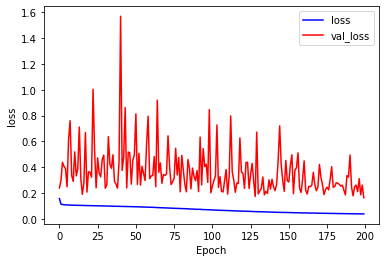

In [42]:
plt.plot( history.history['loss'], color = 'blue', label = 'loss')
plt.plot( history.history['val_loss'], color = 'red', label = 'val_loss')


plt.legend(loc="best")
plt.ylabel('loss')
plt.xlabel('Epoch')
#plt.savefig(f'results/{fname.stem}_loss.png')
plt.show()

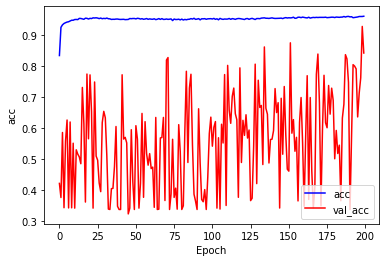

In [43]:
plt.plot( history.history['accuracy'], color = 'blue', label = 'acc')
plt.plot( history.history['val_accuracy'], color = 'red', label = 'val_acc')


plt.legend(loc="best")
plt.ylabel('acc')
plt.xlabel('Epoch')
#plt.savefig(f'results/{fname.stem}_acc.png')
plt.show()

In [44]:
result_test = model.evaluate(x_test, y_test[:, :3])
print('Accuracy of training Set:',result_test[1])
print('Loss of training set:', result_test[0])

9000/9000 [==============================] - 10s 1ms/step
Accuracy of training Set: 0.8539999723434448
Loss of training set: 0.16137623096836937


In [45]:
endtime = datetime.datetime.now()
starttime = datetime.datetime.now()
y_pred = np.zeros(y_test.shape)

In [46]:
starttime = datetime.datetime.now()
y_pred = model.predict(x_test)
y_pred = np.concatenate([y_pred, np.full((len(y_test), 1), 0.)], axis=-1)
endtime = datetime.datetime.now()

print("Prediction %d samples execute time: %s sec" % (len(x_test), (endtime - starttime).total_seconds())) 
print("Average prediction execute time: %f ms" % ((endtime - starttime).total_seconds() / len(x_test) * 1000)) 

Prediction 9000 samples execute time: 8.554035 sec
Average prediction execute time: 0.950448 ms


In [47]:
y_pred

array([[0.519413, 0.815242, 0.538138, 0.      ],
       [0.676404, 0.346197, 0.926973, 0.      ],
       [0.504771, 0.599748, 0.380081, 0.      ],
       [0.694625, 0.543791, 0.956492, 0.      ],
       ...,
       [0.660111, 0.564543, 1.150473, 0.      ],
       [0.553307, 0.796088, 0.544485, 0.      ],
       [0.324282, 0.865978, 0.864177, 0.      ],
       [0.822848, 0.54238 , 0.764715, 0.      ]])

In [48]:
y_test

array([[0.476995, 0.938115, 0.284191, 0.      ],
       [0.766237, 0.258501, 0.930738, 0.      ],
       [0.8734  , 0.991473, 0.243239, 0.      ],
       [0.600475, 0.445276, 0.768293, 0.      ],
       ...,
       [0.577286, 0.43418 , 0.938565, 0.      ],
       [0.446229, 0.989305, 0.431001, 0.      ],
       [0.290957, 0.621086, 0.413559, 0.      ],
       [0.95591 , 0.480937, 0.697495, 0.      ]])

est = quaternion2euler(y_pred); est

In [49]:
np.max(y_pred), np.max(y_train)

(1.3166797161102295, 0.9999736591225339)

In [50]:
successedT1 = 0
successedT2 = 0
successedT3 = 0
successedT4 = 0

maxofMax = 0
sumofMaxErr = 0
pred = None
errlist = []

for i in range(len(x_test)):
    
    if y_pred[i].any() == False:
        pred = np.full(3, 1e-16)
        pred = np.append(pred, 0.)
    else:
        pred = y_pred[i]
        
    estrm = quaternion2rm(pred)
    lbrm = quaternion2rm(y_test[i])
    errrm = estrm @ np.transpose(lbrm)
    
    err = rm2theta(errrm)
        
    maxErr = np.abs(np.max(err) / 3.14 * 180)


    
    errlist.append(maxErr)
    
    if maxErr > maxofMax:
        maxofMax = maxErr

    if maxErr < 0.5:
        successedT1 = successedT1 + 1
    if maxErr < 1:
        successedT2 = successedT2 + 1
    if maxErr < 1.75:
        successedT3 = successedT3 + 1
    if maxErr < 2.5:
        successedT4 = successedT4 + 1


    print(maxErr)
    sumofMaxErr = sumofMaxErr + maxErr


6227838016
14.467705425072714
6.554068472259588
1.997622211299951
4.836254755928387
10.599692157721337
18.696198451796974
6.396930647430941
7.395328461312867
22.80621360196
3.1272122938171276
0.0
11.533510261544233
4.8983954283391915
2.329112529190934
2.3638277193819537
12.61471512601964
17.217267243268324
14.391985221347085
6.852138212781989
14.41460698690824
7.370510677893644
13.544561002429946
3.720962898604373
6.899828871350712
8.508719297542754
13.303619058413389
22.495306653149317
22.199011676658653
1.9143043411584775
13.78197058143118
4.343211260559278
22.329066699431113
5.642686385730791
2.704497884815829
13.138569429133272
0.0
9.362263605083037
10.990841757052321
17.643631704218375
13.75277345943433
15.291354172388091
11.535008239859446
15.086654455815385
6.630558889217335
15.597373138732568
4.152628712801886
12.171636396885281
7.170318725883363
28.17243598602794
3.2388560360935665
9.576222425178145
33.054076367161734
3.112809097846006
0.4678382689645989
4.947352698868469
20.9

In [51]:
print('Max degree error: %.4f degrees' % maxofMax)
print('Average degree error: %.4f degrees' % (sumofMaxErr / len(y_test)))
print(' T1: %.2f \n T2: %.2f \n T3: %.2f \n T4: %.2f \n' 
      % (successedT1 / len(y_test) * 100, 
         successedT2 / len(y_test) * 100, 
         successedT3 / len(y_test) * 100, 
         successedT4 / len(y_test) * 100))

Max degree error: 66.1920 degrees
Average degree error: 12.0359 degrees
 T1: 4.50 
 T2: 5.76 
 T3: 7.91 
 T4: 10.29 



In [52]:
print("Prediction %d samples execute time: %s sec" % (len(x_test), (endtime - starttime).total_seconds())) 
print("Average prediction execute time: %f ms" % ((endtime - starttime).total_seconds() / len(x_test) * 1000)) 

Prediction 9000 samples execute time: 8.554035 sec
Average prediction execute time: 0.950448 ms


In [ ]:
fname.stem

把圖片隨機選九張圖片秀出來，如果save為True會把結果存取下來

In [53]:
def show_pcd_3d(x_data, save=False, name='123'):
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(x_data))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = x_data[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')
        ax.set_title(idx)
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_pcd.png')

In [54]:
def scalar_reduction(x_hat, x_max, x_min):
    reduction = x_hat * (x_max - x_min) + x_min
    return np.float32(reduction)

In [55]:
x_test_no_scalar = scalar_reduction(x_test, x_train_max, x_train_min)

Text(0.5, 0.92, 'original')

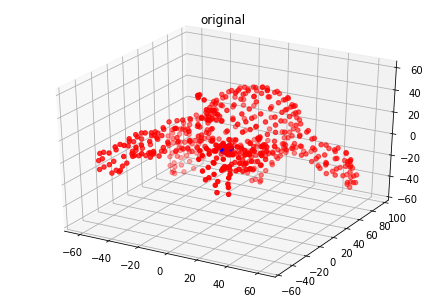

In [56]:
fig = plt.figure()
ax = Axes3D(fig)

x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

ax.scatter(x, y, z, c='r', marker='o')

x_test_sample = x_test_no_scalar[0].reshape(-1, 3)
x = x_test_sample[:, 0]
y = x_test_sample[:, 1]
z = x_test_sample[:, 2]
ax.scatter(x, y, z, c='b', marker='o')
ax.set_title('original')

In [58]:
x_test_est = []
data = np.asarray(downpcd.points)
rotateData = data.copy()

for i in range(len(x_test)):
    if y_pred[i].any() == False:
        pred = np.full(3, 1e-16)
        pred = np.append(pred, 0.)
    else:
        pred = y_pred[i]
        
    rotateData = data.copy()
    for n in range(len(data)):
        rotateData[n] = rotate_with_q(data[n], pred)
        
    rotateData = rotateData.reshape(1, -1)
          
    dis = getAABBSize(rotateData)

    result = get3DMatrix(dis[0], dis[1], dis[2], rotateData, mSize).reshape(-1)
    
    x_test_est.append(result.tolist())
    
x_test_est = np.array(x_test_est).reshape(len(x_test), -1, 3)

In [59]:
np.random.seed(0)
show_pcd_3d(x_test_no_scalar, save=True, name=fname.stem)

NameError: name 'fname' is not defined

In [ ]:
np.random.seed(0)
show_pcd_3d(x_test_est, save=True, name=fname.stem)

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
data_ = x_test_no_scalar[5].reshape(-1, 3)

x = data_[:, 0]
y = data_[:, 1]
z = data_[:, 2]

ax.scatter(x, y, z, c='r', marker='o')


data_ = x_test_est[5].reshape(-1, 3)

x = data_[:, 0]
y = data_[:, 1]
z = data_[:, 2]

ax.scatter(x, y, z, c='b', marker='o')
ax.set_title('register')

In [ ]:
eva_rms(x_test_no_scalar[0], x_test_est[0])

In [ ]:
np.random.seed(0)
show_match_result(x_test_no_scalar, x_test_est, save=True, name=fname.stem)

In [ ]:
rms = []
for i in range(len(x_test)):
    rms.append(eva_rms(x_test_no_scalar[i], x_test_est[i]))

print(f'Max RMS of {fname.stem} testing data: {np.max(rms):.2f}')
print(f'Min RMS of {fname.stem} testing data: {np.min(rms):.2f}')
print(f'Mean RMS of {fname.stem} testing data: {np.mean(rms):.2f}')